# Scan2LOD Predictor
### Prediction Logic that Classifies Facade Data [Images and Conflictmaps (3D-Data)] of the same building with the help of Convolutional Neural Networks.

------------------------------------------------------------------------------
## Input: 572x572 image (.jpg) and 572x572 conflict map (.png)
------------------------------------------------------------------------------
## Output: Class for each individual pixel

The classes that are being output are:

-Facade

-Window

-Door

-Unknown

# 1. IMPORTING LIBRARIES


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import save_image
import json
import pandas as pd
from tqdm.notebook import tqdm  # For progress bars
import time
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. SETTING UP DIRECTORIES

In [3]:
# base directory
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA'

# Folders
INPUT_DIR = os.path.join(BASE_DIR, 'Inputs')
MODEL_DIR = os.path.join(BASE_DIR, 'Models')
OUTPUT_DIR = os.path.join(BASE_DIR, 'Outputs')

# Create folders if they don't exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define paths for specific types of inputs
CONFLICT_MAP_DIR = os.path.join(INPUT_DIR, 'ConflictMaps')
IMAGE_DIR = os.path.join(INPUT_DIR, 'FacadeImages')
GROUND_TRUTH_DIR = os.path.join(INPUT_DIR, 'GroundTruth')  # If available

# Define paths for model files
UNET_MODEL_PATH = os.path.join(MODEL_DIR, 'unet_model.pth')
MASKRCNN_MODEL_PATH = os.path.join(MODEL_DIR, 'maskrcnn_model.pth')

# Create output subdirectories
UNET_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'UNet')
MASKRCNN_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'MaskRCNN')
FUSION_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'Fusion')

os.makedirs(UNET_OUTPUT_DIR, exist_ok=True)
os.makedirs(MASKRCNN_OUTPUT_DIR, exist_ok=True)
os.makedirs(FUSION_OUTPUT_DIR, exist_ok=True)

print("Directory structure initialized!")

Directory structure initialized!


In [4]:
# Adjust to change
# FacadeImage and conflict map paths

CONF_MAP_PATH = os.path.join(INPUT_DIR, 'ConflictMaps', 'Building57_ConflictMap.png')
predictionPath = os.path.join(IMAGE_DIR, 'Building57_FacadeImage.png')


# 3. MODEL ARCHITECTURES (U-Net and MaskRCNN)


In [5]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding='same')  # Using 'same' padding
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding='same')
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding='same')

        # Decoder with size-matching upconvolution
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding='same')
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding='same')

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding='same')
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding='same')

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding='same')
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding='same')
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Decoder with size checking
        xu1 = self.upconv1(xe52)
        if xu1.size() != xe42.size():
            xu1 = F.interpolate(xu1, size=xe42.size()[2:])
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        if xu2.size() != xe32.size():
            xu2 = F.interpolate(xu2, size=xe32.size()[2:])
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        if xu3.size() != xe22.size():
            xu3 = F.interpolate(xu3, size=xe22.size()[2:])
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        if xu4.size() != xe12.size():
            xu4 = F.interpolate(xu4, size=xe12.size()[2:])
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        return out

In [6]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# 4. LOADING MODELS

In [7]:
def load_unet_model(model_path, num_classes=4, device='cuda'):
    """Load a trained U-Net model"""
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model = UNet(n_class=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"U-Net model loaded from: {model_path}")
    return model


In [8]:
def load_maskrcnn_model(model_path, device='cuda'):
    """
    Load a trained Mask R-CNN model
    """
    # This is a placeholder - adjust based on your Mask R-CNN architecture
    try:

        # Initialize model with pre-trained weights
        num_classes = 2
        device = torch.device(device if torch.cuda.is_available() else "cpu")
        model = get_instance_segmentation_model(num_classes)
        weights = torch.load(model_path)

        # Load your trained weights
        model.load_state_dict(weights)
        model.to(device)
        model.eval()
        print(f"Mask R-CNN model loaded from: {model_path}")
        return model
    except Exception as e:
        print(f"Error loading Mask R-CNN model: {str(e)}")


In [9]:
def get_probabilities(self, x):
    """Get both raw logits and normalized probabilities"""
    logits = self.forward(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [10]:
def preprocess_conflict_map(conflict_map_path, device):
    """Preprocess a conflict map for the U-Net model"""
    # Color mappings for conflict map
    CONFLICT_MAP_COLORS = {
        'confirming': (0, 255, 0),  # Green - Confirming
        'unknown': (0, 0, 255),     # Blue - Unknown
        'conflict': (255, 0, 0)     # Red - Conflict
    }

    # Load conflict map as RGB
    conf_map = Image.open(conflict_map_path).convert('RGB')
    conf_map_array = np.array(conf_map)

    # Create input channels based on different conflict map states
    confirming_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['confirming'], axis=2)
    unknown_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['unknown'], axis=2)
    conflict_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['conflict'], axis=2)

    # Stack the masks into a 3-channel tensor
    conf_map_tensor = np.stack([confirming_mask, unknown_mask, conflict_mask], axis=0)
    conf_map_tensor = torch.from_numpy(conf_map_tensor).float().unsqueeze(0).to(device)

    return conf_map_tensor, conf_map_array

In [11]:
def preprocess_image(image_path, device, target_size=(572, 572)):
    # Load and normalize image for Mask R-CNN
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size, Image.LANCZOS)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor, np.array(image)

In [12]:
def preprocess_conflict_map(conflict_map_path, device):
    """Preprocess a conflict map for the U-Net model"""
    # Color mappings for conflict map
    CONFLICT_MAP_COLORS = {
        'confirming': (0, 255, 0),  # Green - Confirming
        'unknown': (0, 0, 255),     # Blue - Unknown
        'conflict': (255, 0, 0)     # Red - Conflict
    }

    # Load conflict map as RGB
    conf_map = Image.open(conflict_map_path).convert('RGB')
    conf_map_array = np.array(conf_map)

    # Create input channels based on different conflict map states
    confirming_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['confirming'], axis=2)
    unknown_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['unknown'], axis=2)
    conflict_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['conflict'], axis=2)

    # Stack the masks into a 3-channel tensor
    conf_map_tensor = np.stack([confirming_mask, unknown_mask, conflict_mask], axis=0)
    conf_map_tensor = torch.from_numpy(conf_map_tensor).float().unsqueeze(0).to(device)

    return conf_map_tensor, conf_map_array

In [13]:
def test_unet_output(model, conflict_map_path, device='cuda'):
    """Test UNet model on a conflict map and visualize outputs"""
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # Preprocess conflict map
    conf_map_tensor, conf_map_array = preprocess_conflict_map(conflict_map_path, device)

    # Forward pass through UNet
    model.eval()
    with torch.no_grad():
        # Get raw logits from model
        logits = model(conf_map_tensor)

        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # Get class predictions
        pred_classes = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

        # Convert to numpy for visualization
        logits_np = logits.squeeze().cpu().numpy()
        probs_np = probs.squeeze().cpu().numpy()

    # Define class names for visualization
    class_names = ['Facade', 'Window', 'Door', 'Unknown']

    # Visualize input
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_map_array)
    plt.title('Input Conflict Map')
    plt.axis('off')
    plt.show()

    # Visualize raw logits
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        plt.subplot(2, 2, i+1)
        plt.imshow(logits_np[i], cmap='viridis')
        plt.colorbar()
        plt.title(f'Raw Logits: {class_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Visualize probabilities
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        plt.subplot(2, 2, i+1)
        plt.imshow(probs_np[i], cmap='viridis', vmin=0, vmax=1)
        plt.colorbar()
        plt.title(f'Probability: {class_name}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Visualize predicted class
    class_colors = {
        0: [105, 105, 105],  # Facade - Gray
        1: [255, 255, 0],    # Window - Yellow
        2: [139, 69, 19],    # Door - Brown
        3: [220, 220, 220]   # Unknown - Light Gray
    }

    # Convert prediction to RGB
    rgb_pred = np.zeros((pred_classes.shape[0], pred_classes.shape[1], 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        rgb_pred[pred_classes == class_idx] = color

    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_pred)
    plt.title('UNet Prediction')
    plt.axis('off')
    plt.show()

    # Print statistics for each class
    print("Class probability statistics:")
    for i, class_name in enumerate(class_names):
        print(f"\n{class_name}:")
        print(f"  Min: {probs_np[i].min():.4f}")
        print(f"  Max: {probs_np[i].max():.4f}")
        print(f"  Mean: {probs_np[i].mean():.4f}")
        print(f"  Pixels predicted as {class_name}: {np.sum(pred_classes == i)} ({np.sum(pred_classes == i)/pred_classes.size*100:.2f}%)")

    # Return processed data for further analysis
    return {
        'raw_logits': logits_np,
        'probabilities': probs_np,
        'predictions': pred_classes
    }


## 5. Model Inference

In [14]:
def get_unet_predictions(model, conflict_map_tensor):
    with torch.no_grad():
        logits, probabilities = model.get_probabilities(conflict_map_tensor)
        predictions = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
        probabilities = probabilities.squeeze().cpu().numpy()

    return predictions, probabilities

Using device: cuda
U-Net model loaded from: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Models/Facade_model_b14_e50_CMPGENREAL_nS.pth


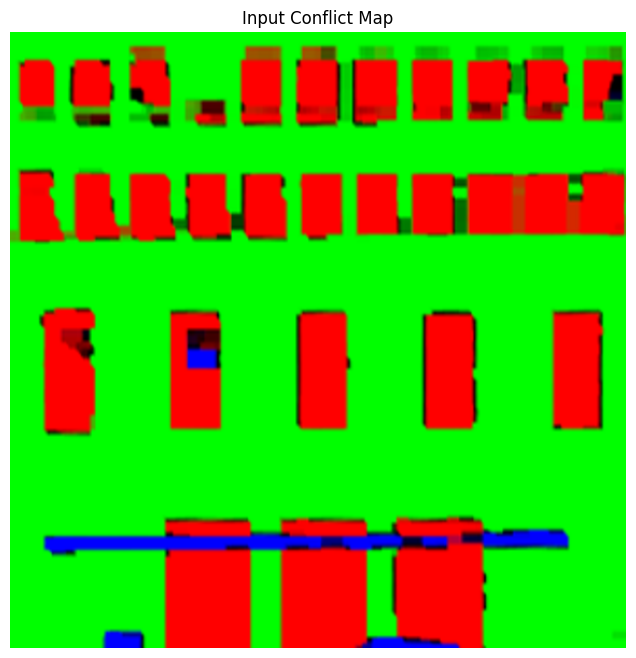

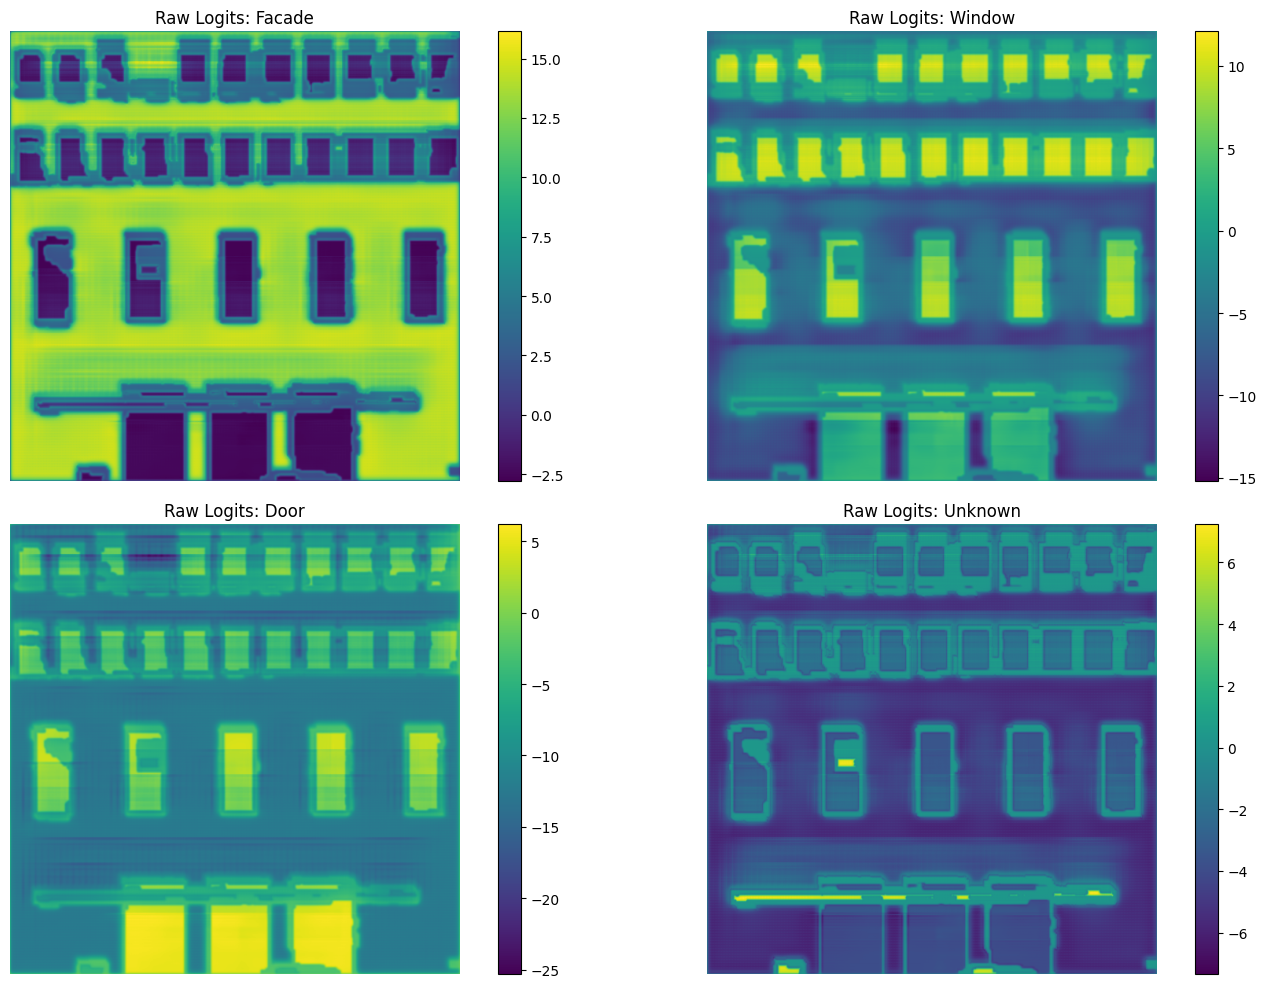

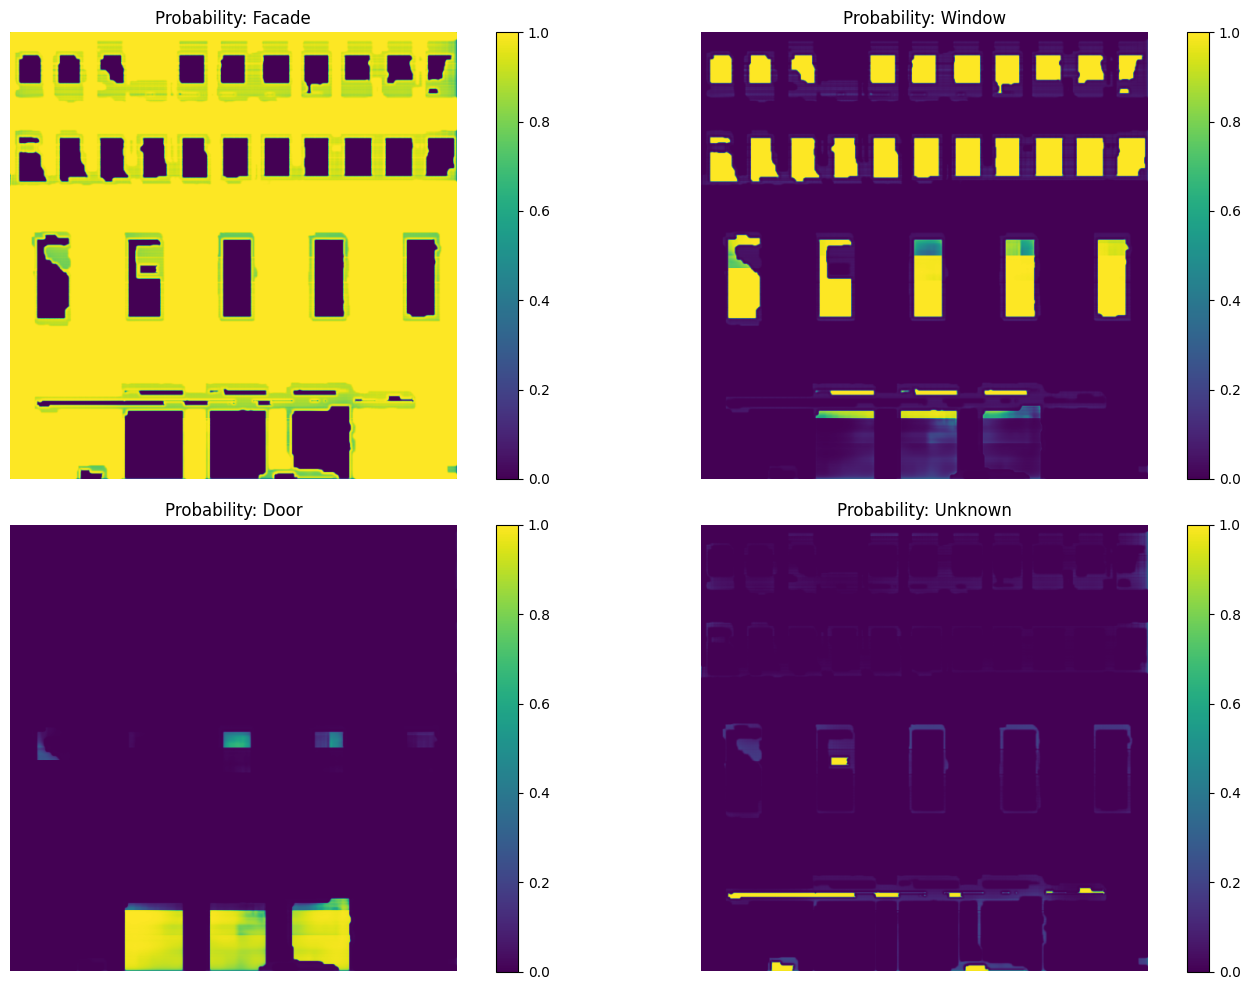

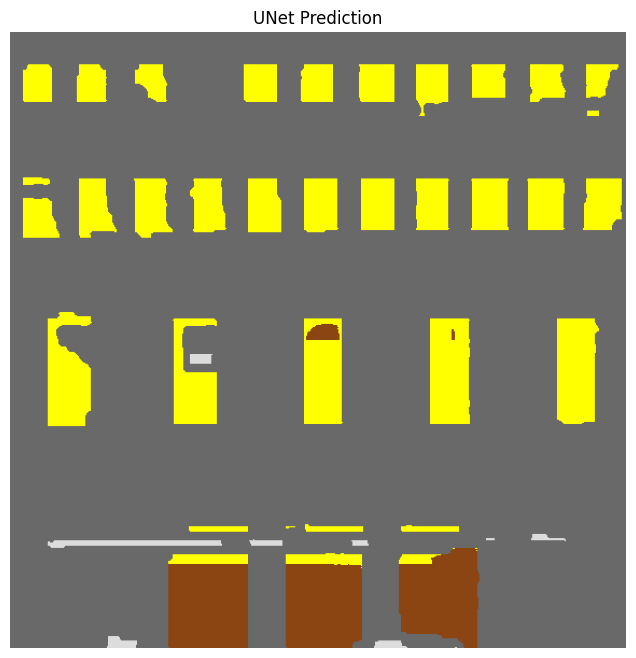

Class probability statistics:

Facade:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.7905
  Pixels predicted as Facade: 264226 (80.76%)

Window:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.1470
  Pixels predicted as Window: 44024 (13.46%)

Door:
  Min: 0.0000
  Max: 0.9987
  Mean: 0.0505
  Pixels predicted as Door: 17155 (5.24%)

Unknown:
  Min: 0.0000
  Max: 0.9999
  Mean: 0.0121
  Pixels predicted as Unknown: 1779 (0.54%)


In [15]:
UNET_PATH = os.path.join(MODEL_DIR, 'Facade_model_b14_e50_CMPGENREAL_nS.pth')

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

unet_model = load_unet_model(UNET_PATH, num_classes=4, device=device)

# Test model output
unet_results = test_unet_output(unet_model, CONF_MAP_PATH, device=device)

In [16]:
device = torch.device(device if torch.cuda.is_available() else "cpu")
MaskRCNN_windows_model = load_maskrcnn_model(os.path.join(MODEL_DIR, 'MASK_RCNN_onlyWindows.pth'))
MaskRCNN_doors_model = load_maskrcnn_model(os.path.join(MODEL_DIR, 'MASK_RCNN_doors.pth'))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 170MB/s]


Mask R-CNN model loaded from: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Models/MASK_RCNN_onlyWindows.pth
Mask R-CNN model loaded from: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Models/MASK_RCNN_doors.pth


In [17]:
predImg = Image.open(predictionPath).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(predImg)

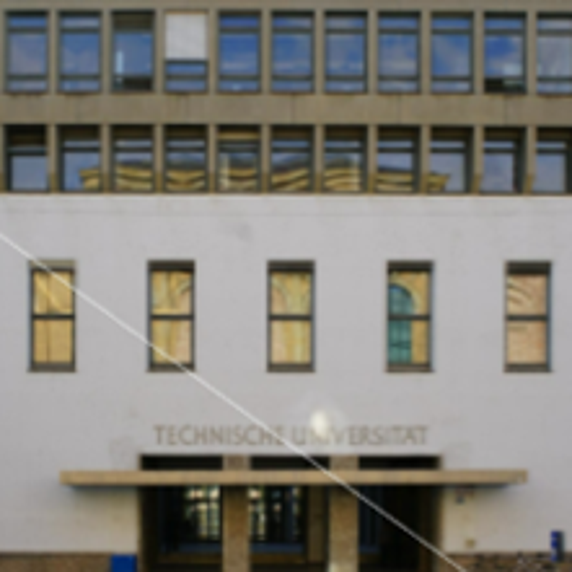

In [18]:
Image.fromarray(img_tensor.mul(255).permute(1, 2, 0).byte().numpy())

In [19]:
with torch.no_grad():
    prediction = MaskRCNN_windows_model([img_tensor.to(device)])
selected_photo = prediction[0]
selected_masks = selected_photo['masks']

#squeeze extra dimension given to the masks
selected_masks = torch.squeeze(selected_masks, 1)

#test = selected_masks[1] #first element of the tensor = first instance mask
num_of_masks = selected_masks.size(dim=0)
x_of_masks = selected_masks.size(dim=1)
y_of_masks = selected_masks.size(dim=2)

list_of_arrays = []
final_mask_windows = selected_masks.sum(axis=0)
for i in range(num_of_masks):
  np_arr = selected_masks[i].cpu().detach().numpy()
  list_of_arrays.append(np_arr)

one_composite_mask_windows = sum(list_of_arrays)

# save_path = path + "/results/wallBmaskFull.jpg"
# save_image(selected_masks, save_path)

In [20]:
with torch.no_grad():
    prediction = MaskRCNN_doors_model([img_tensor.to(device)])
selected_photo = prediction[0]
selected_masks = selected_photo['masks']

#squeeze extra dimension given to the masks
selected_masks = torch.squeeze(selected_masks, 1)

#test = selected_masks[1] #first element of the tensor = first instance mask
num_of_masks = selected_masks.size(dim=0)
x_of_masks = selected_masks.size(dim=1)
y_of_masks = selected_masks.size(dim=2)

list_of_arrays = []
final_mask_doors = selected_masks.sum(axis=0)
for i in range(num_of_masks):
  np_arr = selected_masks[i].cpu().detach().numpy()
  list_of_arrays.append(np_arr)

one_composite_mask_doors = sum(list_of_arrays)

# save_path = path + "/results/wallBmaskFull.jpg"
# save_image(selected_masks, save_path)



In [21]:
prediction

[{'boxes': tensor([[221.9817, 488.5095, 251.4087, 569.7225],
          [353.5081, 484.6851, 443.1795, 572.0000],
          [135.5657, 483.6522, 215.5084, 568.8261],
          [ 58.1452, 124.5034, 101.4238, 193.5630],
          [429.9464, 125.9638, 473.6135, 195.2211],
          [483.1706, 126.4932, 525.0403, 192.2008],
          [252.1507, 482.9604, 320.7983, 567.5225]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.8350, 0.6870, 0.6084, 0.2863, 0.2509, 0.2068, 0.2005],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ..

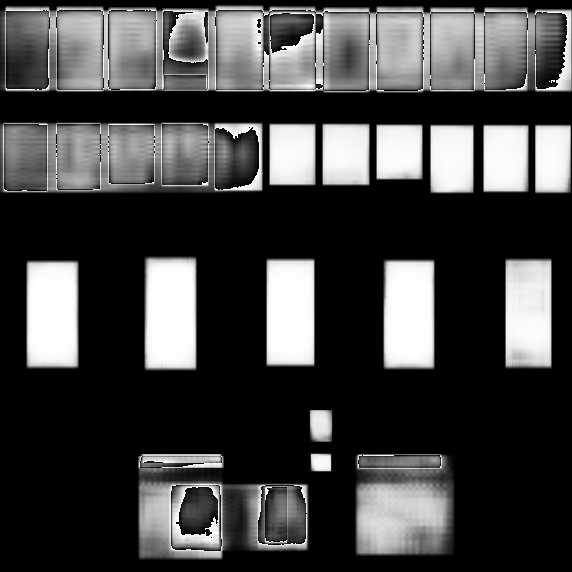

In [22]:
Image.fromarray(final_mask_windows.mul(255).byte().cpu().numpy())

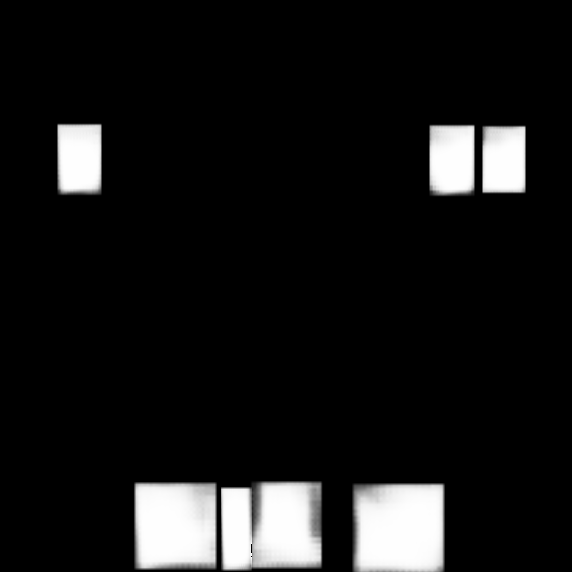

In [23]:
Image.fromarray(final_mask_doors.mul(255).byte().cpu().numpy())

In [24]:
def normalize_maskrcnn_output(mask, epsilon=1e-8):
    """
    Normalize Mask R-CNN output to scale pixel values between 0 and 1.
    Simply finds global min and max and scales all values.

    Parameters:
    mask: Instance masks from Mask R-CNN
    epsilon: Small value to prevent division by zero

    Returns:
    Normalized probability tensor
    """
    # Move tensor to CPU and convert to numpy
    logits = mask.cpu().numpy()

    # Get the global min and max across the entire array, regardless of shape
    min_val = np.min(logits)
    max_val = np.max(logits)

    # Simple min-max normalization
    range_val = max_val - min_val
    if range_val < epsilon:
        # If there's no variation, return zeros in the original shape
        return np.zeros_like(logits)

    # Normalize to [0,1] range
    normalized = (logits - min_val) / range_val

    # If we need a single 2D image as output, take the max across instance dimension if it exists
    if len(normalized.shape) == 3:
        normalized = np.max(normalized, axis=0)

    return normalized

In [25]:
## Unet output
unet_probs = unet_results['probabilities']  # Shape [4, height, width]
#unet_pred = unet_results['predictions']    # Shape [height, width]

## MaskRCNN outputs
window_probs = normalize_maskrcnn_output(final_mask_windows)
window_probs.reshape((572, 572))

#windows_blinds_probs = normalize_maskrcnn_output(final_mask_windows_blinds)
#windows_blinds_probs.reshape((572, 572))

#door_probs = window_probs + windows_blinds_probs



# Apply the condition using NumPy's boolean indexing
#door_probs[door_probs < 1] = 0  # Set values above X to zero

door_probs = normalize_maskrcnn_output(final_mask_doors)

# Renormalize after addition
if np.max(door_probs) > 0:
    door_probs = door_probs / np.max(door_probs)

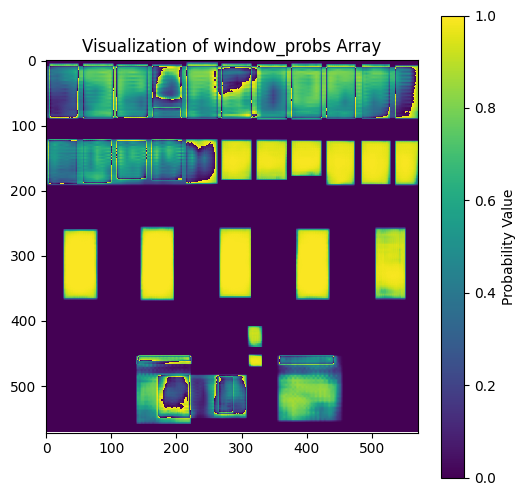

In [26]:
# Plot the heatmap
plt.figure(figsize=(6, 6))
#plt.imshow(unet_probs[1], cmap="viridis", interpolation="nearest")
#plt.imshow(window_probs, cmap="viridis", interpolation="nearest")



plt.imshow(final_mask_windows.mul(255).byte().cpu().numpy()/255, cmap="viridis", interpolation="nearest")

plt.colorbar(label="Probability Value")
plt.title("Visualization of window_probs Array")
plt.show()

## 6. Semantic Fusion

The fusion of the predictions happens with a set of hyperparameters that form our final estimate by weighting the estimates of Windows and Doors segmented by our Unet with the estimates from the MaskRCNN. Facade and Unknown classes will be directly taken from the UNet.

In [27]:
def combine_predictions_linear(unet_probs, window_probs, door_probs):
    """
    Create a linear weighted combination of UNet and Mask R-CNN predictions

    Parameters:
        unet_probs: UNet probabilities [4, height, width] - all classes
        window_probs: Window probabilities from Mask R-CNN [height, width]
        door_probs: Door probabilities from Mask R-CNN [height, width], optional
        window_weight: Weight for Mask R-CNN window prediction (1-window_weight for UNet)
        door_weight: Weight for Mask R-CNN door prediction (1-door_weight for UNet)

    Returns:
        combined_probs: Combined probability tensor [4, height, width]
    """
    # Create a copy of UNet probabilities to avoid modifying original
    combined_probs = unet_probs.copy()

    # For window class [1], apply weighted combination
    if window_probs is not None:
        window_alpha = 3
        window_beta = 3 #3 was valid for 57 // 6 was valid for 57_2
        combined_probs[1] = window_alpha * unet_probs[1] + window_beta * window_probs

    # For door class [2], apply weighted combination if available
    if door_probs is not None:
        door_alpha = 4.5
        door_beta = 1
        combined_probs[2] = door_alpha * unet_probs[2] + door_beta * door_probs

    # Unknowns
    combined_probs[3] = 6* combined_probs[3]

    # Normalize probabilities to sum to 1 for each pixel
    sum_probs = np.sum(combined_probs, axis=0)
    for i in range(combined_probs.shape[0]):
        combined_probs[i] /= sum_probs

    return combined_probs

def adaptive_combine_predictions(unet_probs, window_probs, door_probs=None,
                               window_threshold=0.3, door_threshold=0.3):
    """
    Create an adaptive weighted combination based on UNet confidence

    Parameters:
        unet_probs: UNet probabilities [4, height, width] - all classes
        window_probs: Window probabilities from Mask R-CNN [height, width]
        door_probs: Door probabilities from Mask R-CNN [height, width], optional
        window_threshold: Confidence threshold for windows
        door_threshold: Confidence threshold for doors

    Returns:
        combined_probs: Combined probability tensor [4, height, width]
    """
    # Create a copy of UNet probabilities to avoid modifying original
    combined_probs = unet_probs.copy()


    # Calculate UNet confidence for each class
    window_confidence = unet_probs[1]
    door_confidence = unet_probs[2]

    # WINDOWS: use Mask R-CNN more where UNet is less confident
    if window_probs is not None:
        # Calculate adaptive weights based on confidence
        window_weight = np.where(window_confidence < window_threshold, 0.8, 0.2)

        # Apply weighted combination
        combined_probs[1] = (1 - window_weight) * unet_probs[1] + window_weight * window_probs

    # DOORS: use Mask R-CNN more where UNet is less confident
    if door_probs is not None:
        # Calculate adaptive weights based on confidence
        door_weight = np.where(door_confidence < door_threshold, 0.8, 0.2)

        # Apply weighted combination
        combined_probs[2] = (1 - door_weight) * unet_probs[2] + door_weight * door_probs

    # Normalize probabilities to sum to 1 for each pixel
    sum_probs = np.sum(combined_probs, axis=0)
    for i in range(combined_probs.shape[0]):
        combined_probs[i] /= sum_probs

    return combined_probs



In [28]:
combined_probs = combine_predictions_linear(
     unet_probs,            # From UNet
     window_probs,          # From Window Mask R-CNN
     door_probs
 )

#combined_probs = adaptive_combine_predictions(
 #    unet_probs,            # From UNet
 #    window_probs,          # From Window Mask R-CNN
 #    door_probs,            # From Door Mask R-CNN (optional)
 #    window_threshold=0.4,
 #    door_threshold=0.4
 #)

 # Get final prediction
final_pred = np.argmax(combined_probs, axis=0)

## 7. Final Prediction

In [29]:
def visualize_final_prediction(pred, original_image=None, save_path=None, show_plot=True):
    """
    Visualize the final prediction with optional comparison to inputs and individual model outputs

    Parameters:
        pred: Final prediction array of shape [height, width] with class indices
        original_image: Original input image (optional)
        unet_pred: UNet prediction array (optional)
        maskrcnn_pred: Mask R-CNN prediction array (optional)
        save_path: Path to save the visualization (optional)
        show_plot: Whether to display the plot (default True)
    """
    # Define class colors
    class_colors = {
        0: [105, 105, 105],  # Facade - Gray
        1: [255, 255, 0],    # Window - Yellow
        2: [139, 69, 19],    # Door - Brown
        3: [220, 220, 220]   # Unknown - Light Gray
    }

    # Function to convert prediction to RGB
    def pred_to_rgb(pred_array):
        height, width = pred_array.shape
        rgb = np.zeros((height, width, 3), dtype=np.uint8)
        for class_idx, color in class_colors.items():
            mask = (pred_array == class_idx)
            rgb[mask] = color
        return rgb

    # Convert final prediction to RGB
    rgb_pred = pred_to_rgb(pred)

    # Determine the number of subplots needed
    num_plots = 1
    if original_image is not None:
        num_plots += 1

    # Create figure with appropriate size
    fig = plt.figure(figsize=(5*num_plots, 5))

    # Plot counter
    plot_idx = 1

    # Original image
    if original_image is not None:
        plt.subplot(1, num_plots, plot_idx)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')
        plot_idx += 1

    # Final prediction
    plt.subplot(1, num_plots, plot_idx)
    plt.imshow(rgb_pred)
    plt.title("Final Prediction")
    plt.axis('off')

    # Add a legend
    legend_elements = []
    class_names = ["Facade", "Window", "Door", "Unknown"]
    for i, (class_idx, color) in enumerate(class_colors.items()):
        # Convert RGB to matplotlib format (0-1)
        mpl_color = [c/255 for c in color]
        legend_elements.append(plt.Rectangle((0,0), 1, 1, color=mpl_color, label=class_names[i]))

    # Add the legend to the right side of the plot
    fig.legend(handles=legend_elements, loc='center right', title="Classes")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout for legend

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    # Show if requested
    if show_plot:
        plt.show()
    else:
        plt.close()

    return rgb_pred

Visualization saved to /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/Outputs/fusion_result.png


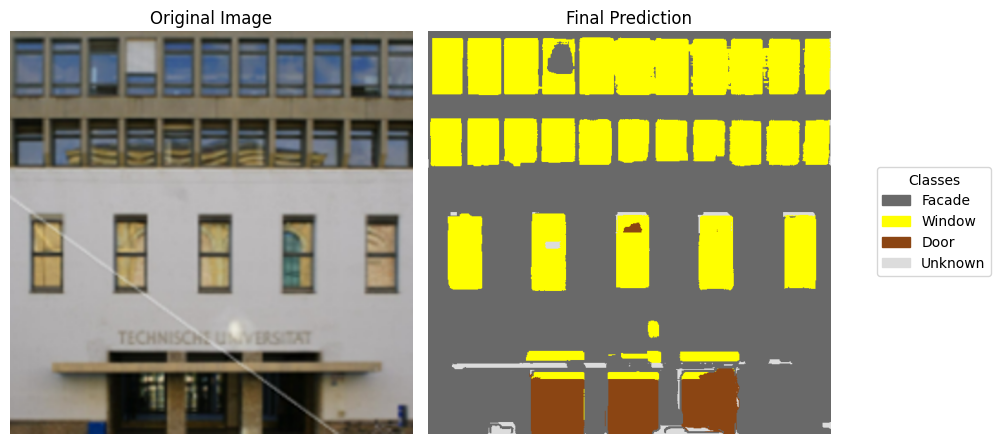

array([[[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [105, 105, 105]],

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [105, 105, 105]],

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [105, 105, 105]],

       ...,

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [105, 105, 105]],

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [105, 105, 105]],

       [[105, 105, 105],
        [105, 105, 105],
        [105, 105, 105],
        ...,
        [105, 105, 105],
        [105, 105, 105],
        [105, 105, 105]]], dtype=uint8)
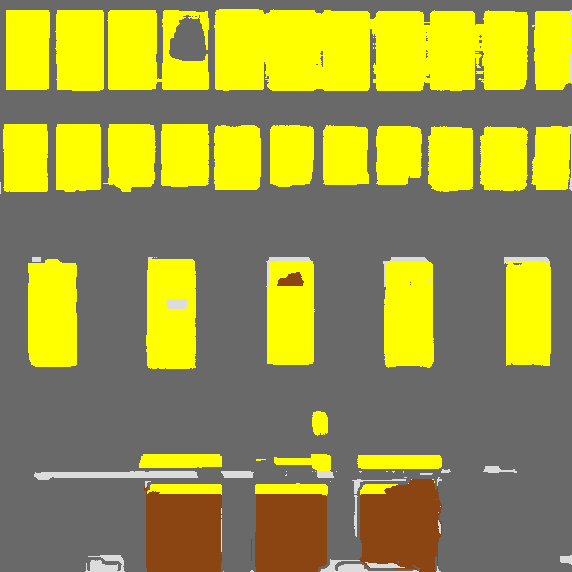

In [30]:
# Get the final prediction
final_pred = np.argmax(combined_probs, axis=0)

# Visualize with comparisons
original_image = np.array(Image.open(predictionPath).convert("RGB"))
visualize_final_prediction(
    final_pred,
    original_image=original_image,
    save_path=os.path.join(OUTPUT_DIR, "fusion_result.png"))

#3D Reconstruction

# 8. Reconstruction with WallMatching

- export unter LOD3 output
- brauchen die Facade ID von der Frontfacade

In [31]:
# Check if the repository already exists
import os

if not os.path.exists('LoD3Framework-'):
    # Clone the repository if it doesn't exist
    !git clone https://github.com/wangyuefeng2017/LoD3Framework-.git
    print("Repository cloned successfully!")
else:
    print("Repository already exists, skipping clone.")

# Change to the repository directory
%cd LoD3Framework-

Cloning into 'LoD3Framework-'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 49 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 2.23 MiB | 5.33 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Repository cloned successfully!
/content/LoD3Framework-


In [32]:
# Install required dependencies
!pip install -q joblib lxml opencv-python

import os
import sys
import joblib
import numpy as np
import cv2
from pathlib import Path
from datetime import datetime
from lxml import etree

# Import all necessary modules from LoD3Framework
import readgml1
import initpara_batch3_stage as initpara_batch3
import creat1
import amendwindow22_stage_PATCH as optimal
import coor_opening4
from datetime import datetime

In [49]:
def clean_predictions(pred, min_window_area=500, min_door_area=600):
    """
    Clean predictions with better window separation.

    Args:
        pred: Prediction array with class indices (0=facade, 1=window, 2=door, 3=unknown)
        min_window_area: Minimum area in pixels for windows to be kept
        min_door_area: Minimum area in pixels for doors to be kept
    """
    cleaned_pred = pred.copy()

    # Process windows (class 1)
    window_mask = (cleaned_pred == 1).astype(np.uint8)

    # First apply erosion to separate potentially connected components
    window_mask = cv2.erode(window_mask, np.ones((3, 3), np.uint8), iterations=2)

    # Then dilate slightly to restore size without reconnecting
    window_mask = cv2.dilate(window_mask, np.ones((2, 2), np.uint8), iterations=1)

    # Remove small window components
    num_components, window_labels = cv2.connectedComponents(window_mask)
    for label in range(1, num_components):
        component = (window_labels == label)
        area = np.sum(component)
        if area < min_window_area:
            window_mask[component] = 0

    # Process doors (class 2)
    door_mask = (cleaned_pred == 2).astype(np.uint8)

    # First apply erosion to separate potentially connected components
    door_mask = cv2.erode(door_mask, np.ones((3, 3), np.uint8), iterations=2)

    # Then dilate slightly to restore size without reconnecting
    door_mask = cv2.dilate(door_mask, np.ones((2, 2), np.uint8), iterations=1)

    # Remove small door components
    num_components, door_labels = cv2.connectedComponents(door_mask)
    for label in range(1, num_components):
        component = (door_labels == label)
        area = np.sum(component)
        if area < min_door_area:
            door_mask[component] = 0

    # Enhance facade areas to ensure they separate windows/doors
    facade_mask = np.ones_like(window_mask)
    facade_mask[window_mask == 1] = 0
    facade_mask[door_mask == 1] = 0

    # Dilate facade to ensure separation
    facade_mask = cv2.dilate(facade_mask, np.ones((3, 3), np.uint8), iterations=1)

    # Apply the dilated facade to ensure separation
    window_mask[facade_mask == 1] = 0
    door_mask[facade_mask == 1] = 0

    # Rebuild the prediction
    cleaned_pred = np.zeros_like(pred)
    cleaned_pred[window_mask == 1] = 1
    cleaned_pred[door_mask == 1] = 2
    cleaned_pred[(window_mask == 0) & (door_mask == 0) & (pred != 3)] = 0
    cleaned_pred[pred == 3] = 3

    return cleaned_pred

In [34]:
def scale_prediction_to_wall_surface(pred, wall_width, wall_height):
    """
    Scale prediction to match wall surface dimensions while preserving aspect ratio.

    Args:
        pred: Prediction array (572x572 or other size)
        wall_width: Actual width of the wall surface
        wall_height: Actual height of the wall surface

    Returns:
        scaled_pred: Prediction scaled to match wall surface
    """
    orig_height, orig_width = pred.shape

    # Calculate target size preserving aspect ratio
    wall_ratio = wall_width / wall_height
    pred_ratio = orig_width / orig_height

    if wall_ratio > pred_ratio:
        # Wall is wider than prediction
        target_width = int(orig_height * wall_ratio)
        target_height = orig_height
    else:
        # Wall is taller than prediction
        target_width = orig_width
        target_height = int(orig_width / wall_ratio)

    # Resize prediction using nearest neighbor to maintain class values
    scaled_pred = cv2.resize(pred.astype(np.uint8), (target_width, target_height),
                           interpolation=cv2.INTER_NEAREST)

    print(f"Scaled prediction from {orig_width}x{orig_height} to {target_width}x{target_height}")
    print(f"Original aspect ratio: {pred_ratio:.2f}, Wall aspect ratio: {wall_ratio:.2f}")

    return scaled_pred

def convert_prediction_to_segment_data(pred, building_id, facade_id, segment_dir):
    """
    Convert prediction to segment data expected by LoD3Framework.

    Args:
        pred: Prediction array
        building_id: ID of the building
        facade_id: ID of the facade
        segment_dir: Directory to save segment data

    Returns:
        segment_file_path: Path to saved segment data
        splash_path: Path to visualization
        window_count: Number of windows detected
        door_count: Number of doors detected
    """
    # Create a unique identifier for this facade
    safe_facade_id = facade_id.replace('/', '_').replace('\\', '_')
    file_prefix = f"{building_id}_{safe_facade_id}"

    # Find contours for windows (class 1)
    window_mask = (pred == 1).astype(np.uint8)
    window_contours, _ = cv2.findContours(window_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    window_boxes = []
    for contour in window_contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area < 50:  # Final small contour filter
            continue
        confidence = 0.95
        window_boxes.append({
            "x": x, "y": y, "width": w, "height": h,
            "class": "window", "confidence": confidence, "area": area
        })

    # Find contours for doors (class 2)
    door_mask = (pred == 2).astype(np.uint8)
    door_contours, _ = cv2.findContours(door_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    door_boxes = []
    for contour in door_contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area < 100:  # Final small contour filter
            continue
        confidence = 0.95
        door_boxes.append({
            "x": x, "y": y, "width": w, "height": h,
            "class": "door", "confidence": confidence, "area": area
        })

    # Sort by area (largest first) to prioritize major elements
    window_boxes = sorted(window_boxes, key=lambda box: box["area"], reverse=True)
    door_boxes = sorted(door_boxes, key=lambda box: box["area"], reverse=True)

    # Print summary
    print(f"Facade {facade_id}:")
    print(f"  - Found {len(window_boxes)} windows and {len(door_boxes)} doors")

    # Only keep position and size info for LoD3Framework compatibility
    for box in window_boxes + door_boxes:
        box.pop("area", None)  # Remove area field

    # Combine all objects
    all_objects = window_boxes + door_boxes

    # Create segment directory if it doesn't exist
    os.makedirs(segment_dir, exist_ok=True)

    # Save as a pickle file in the format expected by the framework
    segment_file_path = os.path.join(segment_dir, f"{file_prefix}.pkl")
    joblib.dump(all_objects, segment_file_path)

    # Save visualization image for reference
    vis_img = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
    vis_img[pred == 0] = [105, 105, 105]  # Facade - Gray
    vis_img[pred == 1] = [255, 255, 0]    # Window - Yellow
    vis_img[pred == 2] = [139, 69, 19]    # Door - Brown
    vis_img[pred == 3] = [220, 220, 220]  # Unknown - Light Gray

    # Create segment directory if it doesn't exist
    os.makedirs(segment_dir, exist_ok=True)

    splash_path = os.path.join(segment_dir, f"{file_prefix}_segments.png")
    cv2.imwrite(splash_path, vis_img[:,:,::-1])  # BGR to RGB for OpenCV

    return segment_file_path, splash_path, len(window_boxes), len(door_boxes)

In [52]:
# Define CityGML namespaces
ns_citygml = "http://www.opengis.net/citygml/2.0"
ns_gml = "http://www.opengis.net/gml"
ns_bldg = "http://www.opengis.net/citygml/building/2.0"
ns_app = "http://www.opengis.net/citygml/appearance/2.0"

def parse_citygml(gml_file_path):
    """
    Parse a CityGML file and extract building information.

    Args:
        gml_file_path: Path to the CityGML file

    Returns:
        tuple: (buildingclasses, buildings)
    """
    try:
        print(f"Parsing CityGML file: {gml_file_path}")
        # Parse the CityGML file
        CITYGML = etree.parse(gml_file_path)
        root = CITYGML.getroot()

        # Find all cityObjectMember elements
        cityObjects = []
        for obj in root.findall('.//{%s}cityObjectMember' % ns_citygml):
            cityObjects.append(obj)

        print(f"\tFound {len(cityObjects)} cityObject(s) in the CityGML file")

        # Find all building elements
        buildings = []
        for cityObject in cityObjects:
            for child in cityObject.findall('.//{%s}Building' % ns_bldg):
                buildings.append(child)

        print(f"\tFound {len(buildings)} building(s) in the CityGML file")

        # Create building classes
        buildingclasses = []
        for b in buildings:
            id = b.get('{%s}id' % ns_gml)
            print(f"\tProcessing building: {id}")
            buildingclasses.append(readgml1.Building(b, id))

        print(f"Successfully parsed {len(buildingclasses)} buildings")
        return buildingclasses, buildings

    except Exception as e:
        print(f"Error parsing CityGML file: {str(e)}")
        import traceback
        traceback.print_exc()
        return [], []

def extract_facade_ids(building):
    """
    Extract facade IDs and dimensions from a building.

    Args:
        building: Building object from the parsed CityGML

    Returns:
        dict: Dictionary mapping facade IDs to surface information
    """
    facade_ids = {}

    # Try to extract from WallSurface elements
    for wall in building.findall('.//{%s}WallSurface' % ns_bldg):
        facade_id = wall.get('{%s}id' % ns_gml)
        if facade_id:
            facade_ids[facade_id] = {'id': facade_id}

            # Try to extract dimensions from LinearRing
            for linear_ring in wall.findall('.//{%s}LinearRing' % ns_gml):
                pos_list = linear_ring.find('.//{%s}posList' % ns_gml)
                if pos_list is not None and pos_list.text:
                    # Extract coordinates
                    coords_text = pos_list.text.strip()
                    coords = [float(x) for x in coords_text.split()]

                    # Extract basic dimensions (very simplified)
                    if len(coords) >= 12:  # At least 4 3D points
                        # Calculate a rough width and height
                        x_coords = coords[0::3]  # Every 3rd element starting from 0
                        y_coords = coords[1::3]  # Every 3rd element starting from 1
                        z_coords = coords[2::3]  # Every 3rd element starting from 2

                        width = max(np.linalg.norm(np.array([x_coords[0], y_coords[0]]) -
                                                  np.array([x_coords[1], y_coords[1]])),
                                   np.linalg.norm(np.array([x_coords[2], y_coords[2]]) -
                                                  np.array([x_coords[3], y_coords[3]])))

                        height = max(z_coords) - min(z_coords)

                        facade_ids[facade_id]['width'] = width
                        facade_ids[facade_id]['height'] = height
                        facade_ids[facade_id]['area'] = width * height

    return facade_ids

In [53]:
def visualize_cleaning_results(original_pred, cleaned_pred, save_path=None):
    """
    Visualize the results of prediction cleaning

    Args:
        original_pred: Original prediction array
        cleaned_pred: Cleaned prediction array
        save_path: Path to save the visualization image

    Returns:
        tuple: (save_path, window_count, door_count)
    """
    class_colors = {
        0: [105, 105, 105],  # Facade - Gray
        1: [255, 255, 0],    # Window - Yellow
        2: [139, 69, 19],    # Door - Brown
        3: [220, 220, 220]   # Unknown - Light Gray
    }

    # Convert predictions to RGB
    original_rgb = np.zeros((original_pred.shape[0], original_pred.shape[1], 3), dtype=np.uint8)
    cleaned_rgb = np.zeros((cleaned_pred.shape[0], cleaned_pred.shape[1], 3), dtype=np.uint8)

    for class_idx, color in class_colors.items():
        original_rgb[original_pred == class_idx] = color
        cleaned_rgb[cleaned_pred == class_idx] = color

    # Create comparison image
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_rgb)
    axes[0].set_title('Original Prediction')
    axes[0].axis('off')

    axes[1].imshow(cleaned_rgb)
    axes[1].set_title('Cleaned Prediction')
    axes[1].axis('off')

    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    # Count windows and doors
    window_count = np.sum(cleaned_pred == 1)
    door_count = np.sum(cleaned_pred == 2)

    return save_path, np.sum(cleaned_pred == 1), np.sum(cleaned_pred == 2)

In [54]:
def process_with_selective_facades(predictions, input_gml_path, specific_facades=None):
    """
    Process building with given predictions for specific facades.

    Args:
        predictions: Dictionary of facade predictions with arbitrary keys
                   {key: {'image': image_array, 'prediction': prediction_array}}
        input_gml_path: Path to the input CityGML file
        specific_facades: Optional list of specific facade IDs to process
    """
    # Create base directories
    base_dir = 'lod3_output'
    os.makedirs(base_dir, exist_ok=True)
    segment_dir = os.path.join(base_dir, 'segments')
    os.makedirs(segment_dir, exist_ok=True)
    param_save_dir = os.path.join(base_dir, 'save_para')
    os.makedirs(param_save_dir, exist_ok=True)
    param_adjust_dir = os.path.join(base_dir, 'adjust_para')
    os.makedirs(param_adjust_dir, exist_ok=True)
    texture_dir = os.path.join(base_dir, 'facade_textures')
    os.makedirs(texture_dir, exist_ok=True)
    output_dir = os.path.join(base_dir, 'output_gml')
    os.makedirs(output_dir, exist_ok=True)

    # Create the output file path with _ex suffix
    output_gml_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(input_gml_path))[0]}_ex.gml")

    print(f"Input GML: {input_gml_path}")
    print(f"Output GML will be: {output_gml_path}")

    # Step 2: Parse CityGML to get building information
    buildingclasses, buildings = parse_citygml(input_gml_path)

    if not buildingclasses:
        print("No buildings found in the CityGML file.")
        return

    # Process each building
    for i, (building_class, building) in enumerate(zip(buildingclasses, buildings)):
        building_id = building_class.id
        print(f"\nProcessing building: {building_id}")

        # Get all available facade IDs
        all_facades = extract_facade_ids(building)

        print(f"Available facades for building {building_id}:")
        for facade_id, info in all_facades.items():
            width = info.get('width', 'unknown')
            height = info.get('height', 'unknown')
            print(f" - {facade_id} (width: {width}, height: {height})")

        # Choose which facades to process based on user input or prediction keys
        if specific_facades:
            # Use the specified facades if provided
            facades_to_process = [f for f in specific_facades if f in all_facades]
            print(f"\nSelectively processing {len(facades_to_process)} specified facades")
        else:
            # Auto-map based on provided predictions
            prediction_keys = list(predictions.keys())
            real_facade_ids = list(all_facades.keys())

            # If prediction keys look like they might be real facade IDs, try matching directly
            if any('DEBY' in key for key in prediction_keys):
                facades_to_process = [f for f in prediction_keys if f in all_facades]
                print(f"\nDirectly matching {len(facades_to_process)} facade IDs from predictions")
            else:
                # Otherwise, match predictions to facades in order
                facades_to_process = real_facade_ids[:len(prediction_keys)]
                print(f"\nAuto-mapping {len(facades_to_process)} predictions to facades in order")

        if not facades_to_process:
            print("No facades to process! Check your facade IDs or prediction keys.")
            continue

        # Create a mapping from real facades to predictions
        mapped_predictions = {}
        rel = {}  # Relationship dictionary for the framework

        if specific_facades or any('DEBY' in key for key in predictions.keys()):
            # Direct mapping - facade IDs should match prediction keys
            for facade_id in facades_to_process:
                if facade_id in predictions:
                    mapped_predictions[facade_id] = predictions[facade_id]
                    print(f"Using prediction for facade ID '{facade_id}'")
                else:
                    print(f"No prediction found for facade ID '{facade_id}'")
        else:
            # Ordered mapping - match predictions to facades in order
            for i, facade_id in enumerate(facades_to_process):
                if i < len(prediction_keys):
                    pred_key = prediction_keys[i]
                    mapped_predictions[facade_id] = predictions[pred_key]
                    print(f"Mapping prediction '{pred_key}' to facade ID '{facade_id}'")

        # Process each facade
        for facade_id, pred_data in mapped_predictions.items():
            print(f"\nProcessing facade: {facade_id}")

            # Clean prediction
            pred = pred_data['prediction']
            print(f"Original prediction shape: {pred.shape}")

            # Clean up the prediction
            cleaned_pred = clean_predictions(pred, min_window_area=200, min_door_area=300)

            # Visualize cleaning results
            cleaning_vis_path = os.path.join(output_dir, f"{facade_id.replace('/', '_')}_cleaning_results.png")
            _, window_count, door_count = visualize_cleaning_results(pred, cleaned_pred, cleaning_vis_path)
            print(f"Cleaning visualization saved to: {cleaning_vis_path}")

            # Get wall dimensions from extracted facade info
            wall_width = all_facades[facade_id].get('width', 10.0)
            wall_height = all_facades[facade_id].get('height', 10.0)

            # Scale prediction to match wall surface
            scaled_pred = scale_prediction_to_wall_surface(cleaned_pred, wall_width, wall_height)
            print(f"Scaled prediction shape: {scaled_pred.shape}")

            # Save texture image for visualization
            image = pred_data['image']
            texture_path = os.path.join(texture_dir, f"{building_id}_{facade_id.replace('/', '_')}.png")
            if hasattr(image, 'numpy'):
                image_array = image.numpy()
            else:
                image_array = image

            if image_array.max() <= 1.0:
                image_array = (image_array * 255).astype(np.uint8)

            cv2.imwrite(texture_path, image_array)

            # Convert prediction to segment data
            segment_path, splash_path, num_windows, num_doors = convert_prediction_to_segment_data(
                scaled_pred, building_id, facade_id, segment_dir)

            print(f"Segment data saved to: {segment_path}")
            print(f"Segment visualization saved to: {splash_path}")
            print(f"Added {num_windows} windows and {num_doors} doors to facade {facade_id}")

            # Add to relationship dictionary
            rel[facade_id] = {
                'img': os.path.basename(texture_path),
                'scale': 1.0  # Default scale
            }

        # Save relationship file for the LoD3Framework
        rel_path = os.path.join(base_dir, 'img_model.pkl')
        joblib.dump(rel, rel_path)
        print(f"Saved relationship file to: {rel_path}")

        # Generate LoD3 model using the framework's functions
        print("\nGenerating LoD3 model using LoD3Framework...")

        # Generate parameters for each image
        obtainparaset(segment_dir, param_save_dir, rel)

        # Optimize parameters
        optimal.optimalwindows(segment_dir, texture_dir, rel, param_adjust_dir)

        # Create LOD3 model
        suffix = f'LOD3_{datetime.now().strftime("%Y%m%d_%H%M")}'
        creat1.writelod3(suffix, param_adjust_dir, input_gml_path, buildingclasses, buildings, rel)

        print(f"\nLoD3 model generation complete!")
        print(f"Output CityGML file: {os.path.join('lod3', f'{suffix}.gml')}")

        return os.path.join('lod3', f'{suffix}.gml')

In [55]:
def obtainparaset(path_read, path_save, rel):
    """
    Process segmentation results to generate parameter sets for LOD3 reconstruction

    Args:
        path_read: Directory containing segmentation results
        path_save: Directory to save parameter sets
        rel: Relationship dictionary mapping facade IDs to texture info
    """
    print("Generating parameter sets from segmentation results...")
    ct = 0

    for facade_id, value in rel.items():
        img = value['img']
        imgname = img.split('/')[-1].split('.')[0]
        para_path = os.path.join(path_read, f"{imgname}.pkl")
        image_path = os.path.join(path_read, f"{imgname}_segments.png")
        scale = value['scale']

        try:
            # Generate parameters using the framework function
            para_set_create = initpara_batch3.get_para(image_path, para_path, scale)

            # Save parameter set
            joblib.dump(para_set_create, os.path.join(path_save, f"{imgname}.pkl"))

            print(f'Processed {ct+1}/{len(rel)}: {imgname}')
            ct += 1
        except Exception as e:
            print(f"Error processing {imgname}: {str(e)}")

    print(f"Parameter generation complete: {ct}/{len(rel)} successfully processed")

In [66]:
def generate_lod3_from_predictions(predictions, input_gml_path, output_dir='lod3_output', specific_facades=None):
    """
    Complete pipeline to generate LOD3 models from semantic predictions
    """
    # Create base directories
    os.makedirs(output_dir, exist_ok=True)
    segment_dir = os.path.join(output_dir, 'segments')
    os.makedirs(segment_dir, exist_ok=True)
    param_save_dir = os.path.join(output_dir, 'save_para')
    os.makedirs(param_save_dir, exist_ok=True)
    param_adjust_dir = os.path.join(output_dir, 'adjust_para')
    os.makedirs(param_adjust_dir, exist_ok=True)
    texture_dir = os.path.join(output_dir, 'appearances')
    os.makedirs(texture_dir, exist_ok=True)
    output_gml_dir = os.path.join(output_dir, 'output_gml')
    os.makedirs(output_gml_dir, exist_ok=True)

    print(f"Input GML: {input_gml_path}")

    # Step 1: Parse CityGML to get building information
    buildingclasses, buildings = parse_citygml(input_gml_path)

    if not buildingclasses:
        print("No buildings found in the CityGML file.")
        return None

    # Step 2: Process each building
    rel = {}  # Relationship dictionary for the framework

    for i, (building_class, building) in enumerate(zip(buildingclasses, buildings)):
        building_id = building_class.id
        print(f"\nProcessing building: {building_id}")

        # Get all available facade IDs
        all_facades = extract_facade_ids(building)

        # Choose which facades to process
        facades_to_process = select_facades_to_process(all_facades, predictions, specific_facades)

        if not facades_to_process:
            print("No facades to process! Check your facade IDs or prediction keys.")
            continue

        # Process each facade
        for facade_id in facades_to_process:
            if facade_id not in predictions:
                print(f"No prediction found for facade ID '{facade_id}'")
                continue

            pred_data = predictions[facade_id]
            print(f"\nProcessing facade: {facade_id}")

            # Process prediction and save results
            process_facade_prediction(
                facade_id,
                pred_data,
                all_facades,
                building_id,
                segment_dir,
                texture_dir,
                rel
            )

    # Step 3: Save relationship file for the LoD3Framework
    rel_path = os.path.join(output_dir, 'img_model.pkl')
    joblib.dump(rel, rel_path)
    print(f"Saved relationship file to: {rel_path}")

    # Step 4: Generate parameters - WITH ADDED ERROR HANDLING
    print("\nGenerating parameter sets...")
    for facade_id, value in rel.items():
        img = value['img']
        imgname = os.path.splitext(img)[0]  # Remove extension properly

        # Create standardized segment and image paths
        segment_file = f"{building_id}_{facade_id.replace('/', '_').replace('-', '_')}"
        para_path = os.path.join(segment_dir, f"{segment_file}.pkl")
        image_path = os.path.join(segment_dir, f"{segment_file}_segments.png")

        # Verify files exist before processing
        if not os.path.exists(para_path):
            print(f"WARNING: Parameter file not found: {para_path}")
            # Try an alternative path format
            para_path = os.path.join(segment_dir, f"{imgname}.pkl")
            if not os.path.exists(para_path):
                print(f"ERROR: Could not find parameter file for {imgname}")
                continue

        if not os.path.exists(image_path):
            print(f"WARNING: Image file not found: {image_path}")
            # Try an alternative path format
            image_path = os.path.join(segment_dir, f"{imgname}_segments.png")
            if not os.path.exists(image_path):
                print(f"ERROR: Could not find image file for {imgname}")
                continue

        scale = value['scale']

        print(f"Processing {imgname} with files:")
        print(f"  - Parameter file: {para_path}")
        print(f"  - Image file: {image_path}")

        try:
            # Custom parameter generation using our own code instead of the framework
            # This is a temporary fix until we can make the framework function work
            segment_data = joblib.load(para_path)

            # Create a simple parameter set structure
            p_window = []
            for item in segment_data:
                if item.get('class') == 'window':
                    x, y = item.get('x', 0), item.get('y', 0)
                    w, h = item.get('width', 0), item.get('height', 0)
                    p_window.append(((x, y), w, h))

            # Create a basic parameter set
            para_set = {
                'window': {'eachfloor': {}},
                'Stairwell_window': {'eachfloor': {}},
                'door': {'eachfloor': {}},
                'balcony': {'eachfloor': {}}
            }

            # Create the full parameter structure
            para_set_create = {
                'W': all_facades[facade_id].get('width', 10.0),
                'H': all_facades[facade_id].get('height', 10.0),
                'R': 0.0,
                'para_set': para_set
            }

            # Save parameter set
            joblib.dump(para_set_create, os.path.join(param_save_dir, f"{imgname}.pkl"))
            print(f"Created parameters for {imgname} with {len(p_window)} windows")

        except Exception as e:
            print(f"Error generating parameters for {imgname}: {str(e)}")
            import traceback
            traceback.print_exc()

    # Step 5: Custom parameter optimization - skipping the original function
    print("\nSkipping parameter optimization due to compatibility issues...")
    # Instead of calling optimal.optimalwindows, copy parameters directly
    import shutil
    for filename in os.listdir(param_save_dir):
        shutil.copy(
            os.path.join(param_save_dir, filename),
            os.path.join(param_adjust_dir, filename)
        )

    # Step 6: Create LOD3 model
    suffix = f'LOD3_{datetime.now().strftime("%Y%m%d_%H%M")}'
    output_path = os.path.join(output_gml_dir, f'{suffix}.gml')

    print("\nGenerating LOD3 CityGML model...")
    try:
        # Create CityGML document
        CityGMLs = {}
        CityGMLs[suffix] = creat1.createCityGML(suffix)

        # Process each building
        for i in range(len(buildingclasses)):
            bldinf = buildingclasses[i]
            id = buildings[i].attrib['{%s}id' % creat1.ns_gml]
            print(f'Creating LOD3 for building {id}')
            creat1.CityGMLbuildingLOD3Semantics(buildings[i], CityGMLs[suffix], bldinf, rel, param_adjust_dir, id)

        # Store CityGML
        creat1.storeCityGML(CityGMLs, suffix)

        print(f"\nLOD3 model generation complete!")
        print(f"Output CityGML file: {os.path.join('lod3', f'{suffix}.gml')}")

        return os.path.join('lod3', f'{suffix}.gml')
    except Exception as e:
        print(f"Error generating LOD3 model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

In [68]:
def custom_process_predictions(predictions, input_gml_path, output_dir='lod3_output', specific_facades=None):
    """
    Process predictions with a patched version to fix the innerpoint error
    """
    # Create directories
    os.makedirs(output_dir, exist_ok=True)
    save_para_dir = os.path.join(output_dir, 'save_para')
    os.makedirs(save_para_dir, exist_ok=True)

    # Parse CityGML
    buildingclasses, buildings = parse_citygml(input_gml_path)

    if not buildingclasses:
        print("No buildings found in the CityGML file.")
        return None

    # Create relationship dictionary
    rel = {}

    # Process predictions to parameters
    for facade_id, pred_data in predictions.items():
        pred = pred_data['prediction']
        image = pred_data['image']

        # Find windows
        window_mask = (pred == 1).astype(np.uint8)
        contours, _ = cv2.findContours(window_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        p_window = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w*h > 200:  # Filter tiny regions
                p_window.append(((x, y), w, h))

        # Create simple parameters
        h, w = pred.shape
        para_set = {
            'window': {'eachfloor': {
                '0': {
                    'floor': {'sf': 1, 'wf': w, 'hf': h/2},
                    'w_bound': 0,
                    'num_vertices': 1,
                    'nwindow': len(p_window),
                    'h_gap': 0,
                    'mode': 'sysm',
                    'num_eachwindow': {'0': {'sw': len(p_window), 'ww': p_window[0][1] if p_window else 20, 'hw': p_window[0][2] if p_window else 30}},
                    'edge': {'d_intra': {'0': 1}, 'd_inter': {}}
                }
            }},
            'door': {'eachfloor': {}},
            'Stairwell_window': {'eachfloor': {}},
            'balcony': {'eachfloor': {}}
        }

        para_set_create = {
            'W': w,
            'H': h,
            'R': 0.0,
            'para_set': para_set
        }

        # Add to rel dictionary
        rel[facade_id] = {
            'img': f"{facade_id.replace('/', '_')}.png",
            'scale': 1.0
        }

        # Save image
        img_path = os.path.join(output_dir, f"{facade_id.replace('/', '_')}.png")
        if isinstance(image, np.ndarray):
            cv2.imwrite(img_path, image)

        # Save parameter set
        filename = facade_id.replace('/', '_').replace('-', '_')
        joblib.dump(para_set_create, os.path.join(save_para_dir, f"{filename}.pkl"))

    # Save relationship file
    joblib.dump(rel, os.path.join(output_dir, 'img_model.pkl'))

    # Define our patched version of the wallface function with innerpoint calculation
    def patched_wallface(b, bldg, bldinf, rel_model, para_path):
        """Patched version of wallface that ensures innerpoint is defined"""

        # Define a default innerpoint using a very simple method
        # This is the key fix - we ensure innerpoint is calculated regardless of envelope
        def calculate_default_innerpoint(walls):
            """Calculate a default innerpoint if envelope is missing"""
            # Collect all coordinates from wall surfaces
            all_points = []

            for wall in walls:
                for linear_ring in wall.findall('.//{%s}LinearRing' % creat1.ns_gml):
                    pos_list = linear_ring.find('.//{%s}posList' % creat1.ns_gml)
                    if pos_list is not None and pos_list.text:
                        # Extract coordinates
                        coords_text = pos_list.text.strip()
                        coords = [float(x) for x in coords_text.split()]

                        # Extract 3D points
                        for i in range(0, len(coords), 3):
                            if i+2 < len(coords):
                                all_points.append((coords[i], coords[i+1], coords[i+2]))

            # Calculate center point
            if all_points:
                x_sum = sum(p[0] for p in all_points)
                y_sum = sum(p[1] for p in all_points)
                z_sum = sum(p[2] for p in all_points)
                num_points = len(all_points)
                return (x_sum/num_points, y_sum/num_points, z_sum/num_points)
            else:
                # Absolute fallback
                return (0, 0, 0)

        # Initialize innerpoint to None so we can check if it gets set
        innerpoint = None

        # Try to get innerpoint from building envelope (original code path)
        if b.find("{%s}boundedBy" % creat1.ns_gml) is not None:
            print('Found building envelope')
            bd = b.find("{%s}boundedBy" % creat1.ns_gml)

            elop = bd.find('{%s}Envelope' % creat1.ns_gml)
            if elop is not None:
                print('Found envelope specification')
                srsname = elop.attrib['srsName']
                boundedBy = etree.SubElement(bldg, "{%s}boundedBy" % creat1.ns_gml)
                Envelope = etree.SubElement(boundedBy, "{%s}Envelope" % creat1.ns_gml)
                Envelope.attrib['srsName'] = srsname
                Envelope.attrib['srsDimension'] = "3"

                lc = elop.find('{%s}lowerCorner' % creat1.ns_gml)
                if lc is not None:
                    lowercorner = etree.SubElement(Envelope, "{%s}lowerCorner" % creat1.ns_gml)
                    lowercorner.text = lc.text

                uc = elop.find('{%s}upperCorner' % creat1.ns_gml)
                if uc is not None:
                    uppercorner = etree.SubElement(Envelope, "{%s}upperCorner" % creat1.ns_gml)
                    uppercorner.text = uc.text

                # Calculate innerpoint from envelope
                if lc is not None and uc is not None:
                    innerpoint = creat1.calinnerpoint(lc.text, uc.text)
                    print(f"Calculated innerpoint from envelope: {innerpoint}")

        # If innerpoint is still None, calculate it from walls
        if innerpoint is None:
            print("Envelope not found or no coordinates, calculating innerpoint from walls")
            walls = []
            for child in b.getiterator():
                if child.tag == '{%s}WallSurface' % creat1.ns_bldg:
                    walls.append(child)

            innerpoint = calculate_default_innerpoint(walls)
            print(f"Calculated fallback innerpoint: {innerpoint}")

        # Now the rest of the original function...
        plyidsetw, plyidsetr, plyidsetg = [], [], []

        # Continue with original function implementation
        # This is a simplified version calling the original implementation with our innerpoint
        print("Continuing with original wallface implementation using our calculated innerpoint")
        try:
            # Call the original wallface with our guaranteed innerpoint
            original_wallface = creat1.wallface

            # Create a patch function that fixes the innerpoint issue
            def wallface_patch(b, bldg, bldinf, rel_model, para_path):
                # Store the original counterclockwise function
                original_counterclockwise = creat1.counterclockwise

                # Create a patched counterclockwise that injects our innerpoint if needed
                def counterclockwise_patch(poslists, point=None, label=None):
                    # Use our calculated innerpoint if none provided
                    if point is None:
                        point = innerpoint
                    return original_counterclockwise(poslists, point, label)

                # Replace the function temporarily
                creat1.counterclockwise = counterclockwise_patch

                try:
                    # Call original with our patched function
                    return original_wallface(b, bldg, bldinf, rel_model, para_path)
                finally:
                    # Restore original function
                    creat1.counterclockwise = original_counterclockwise

            # Call our patched function
            return wallface_patch(b, bldg, bldinf, rel_model, para_path)

        except Exception as e:
            print(f"Error in patched wallface: {e}")
            import traceback
            traceback.print_exc()

    # Create LOD3 with patched function
    suffix = f'LOD3_{datetime.now().strftime("%Y%m%d_%H%M")}'

    try:
        # Save the original function
        original_wallface = creat1.wallface

        # Replace with our patched version
        creat1.wallface = patched_wallface

        # Create CityGML document
        CityGMLs = {}
        CityGMLs[suffix] = creat1.createCityGML(suffix)

        # Process each building
        for i in range(len(buildingclasses)):
            bldinf = buildingclasses[i]
            id = buildings[i].attrib['{%s}id' % creat1.ns_gml]
            print(f'Creating LOD3 for building {id}')
            creat1.CityGMLbuildingLOD3Semantics(buildings[i], CityGMLs[suffix], bldinf, rel, save_para_dir, id)

        # Store CityGML
        creat1.storeCityGML(CityGMLs, suffix)

        output_path = os.path.join('lod3', f'{suffix}.gml')
        print(f"\nLOD3 model generation complete!")
        print(f"Output CityGML file: {output_path}")

        return output_path
    except Exception as e:
        print(f"Error generating LOD3 model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    finally:
        # Restore original function
        creat1.wallface = original_wallface

In [69]:
# After running your prediction model and getting final_pred
predictions = {
    'DEBY_LOD2_4959457_e030de07-0827-4f7b-9657-9070e768b8f7': {'image': original_image, 'prediction': final_pred}
}

# Upload CityGML file
print("Please upload your CityGML file...")
uploaded = files.upload()

if not uploaded:
    print("No file was uploaded.")
else:
    # Get the first uploaded file
    filename = next(iter(uploaded.keys()))
    input_gml_path = os.path.join(BASE_DIR, filename)

    # Move the file to the right location
    with open(input_gml_path, 'wb') as f:
        f.write(uploaded[filename])

    print(f"File saved to: {input_gml_path}")

    # Process with our custom patched function
    output_gml_path = custom_process_predictions(
        predictions,
        input_gml_path,
        output_dir='lod3_output',
        specific_facades=['DEBY_LOD2_4959457_e030de07-0827-4f7b-9657-9070e768b8f7']
    )

    if output_gml_path and os.path.exists(output_gml_path):
        print(f"LOD3 model generated successfully at: {output_gml_path}")
        # You can also provide a download link
        files.download(output_gml_path)
    else:
        print("Failed to generate LOD3 model")

Please upload your CityGML file...


Saving DEBY_LOD2_4959457.gml to DEBY_LOD2_4959457.gml
File saved to: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/DEBY_LOD2_4959457.gml
Parsing CityGML file: /content/drive/MyDrive/Colab Notebooks/Scan2LOD_DATA/DEBY_LOD2_4959457.gml
	Found 1 cityObject(s) in the CityGML file
	Found 1 building(s) in the CityGML file
	Processing building: DEBY_LOD2_4959457
Successfully parsed 1 buildings
Creating LOD3 for building DEBY_LOD2_4959457
Envelope not found or no coordinates, calculating innerpoint from walls
Calculated fallback innerpoint: (691007.7921871102, 5336037.110143458, 528.7081767151783)
Continuing with original wallface implementation using our calculated innerpoint
Envelope not found or no coordinates, calculating innerpoint from walls
Calculated fallback innerpoint: (691007.7921871102, 5336037.110143458, 528.7081767151783)
Continuing with original wallface implementation using our calculated innerpoint
Envelope not found or no coordinates, calculating innerpoint from walls


Traceback (most recent call last):
  File "<ipython-input-68-8884272b679d>", line 191, in patched_wallface
    return wallface_patch(b, bldg, bldinf, rel_model, para_path)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-68-8884272b679d>", line 185, in wallface_patch
    return original_wallface(b, bldg, bldinf, rel_model, para_path)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-68-8884272b679d>", line 155, in patched_wallface
    innerpoint = calculate_default_innerpoint(walls)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-68-8884272b679d>", line 93, in calculate_default_innerpoint
    pos_list = linear_ring.find('.//{%s}posList' % creat1.ns_gml)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "src/lxml/etree.pyx", line 1574, in lxml.etree._Element.find
  File "src/lxml/_elementpath.py", line 319, in lxml._elementpath.find
  File "src/lxml/_element

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>